In [1]:
# Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import Dependencies
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
database_path="Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [5]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Get the name of the columns for 'measurement' table
inspector=inspect(engine)
columns_measurement=inspector.get_columns("measurement")
for column_me in columns_measurement:
    print(column_me["name"],column_me["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Get the name of the columns for 'station' table
columns_station=inspector.get_columns("station")
for column_st in columns_station:
    print(column_st["name"],column_st["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date in the data set is: {recent_date}")

The most recent date in the data set is: ('2017-08-23',)


The date to start the query from is: 2016-08-23


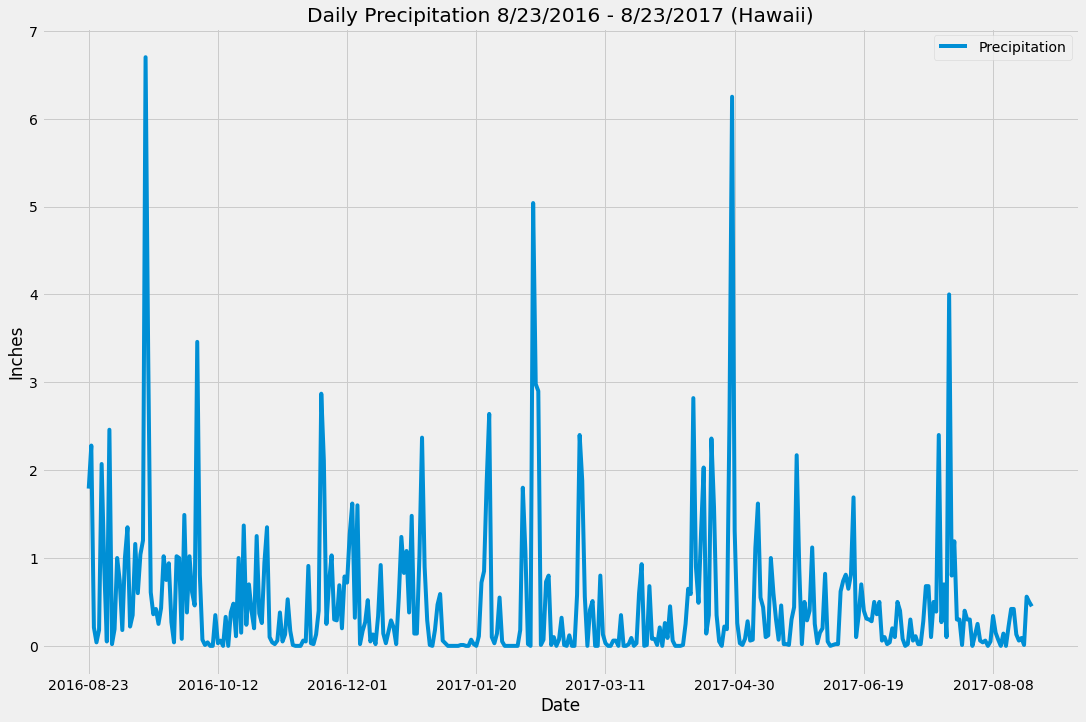

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
old_date=dt.date(2017,8,23)-dt.timedelta(days=365)
print(f"The date to start the query from is: {old_date}")
# Perform a query to retrieve the data and precipitation scores
max_precipitation=session.query(Measurement.date,func.max(Measurement.prcp)).filter(Measurement.date>="2016-08-23").\
    group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
max_prcp_df=pd.DataFrame(max_precipitation,columns=["Date","Precipitation"]).set_index("Date")
max_prcp_df

# Sort the dataframe by date
max_prcp_df.sort_values(by="Date",ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
max_prcp_df.plot(figsize=(15,10))

# Format the plot
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Daily Precipitation 8/23/2016 - 8/23/2017 (Hawaii)")

# Save the plot as .png file
plt.savefig("Images/PRCP.png")

# Display the plot
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=old_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(precipitation,columns=["Date","Precipitation"]).set_index("Date")
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
no_stations=session.query(Station.name).count()
print(f"The total number of stations is: {no_stations}")

The total number of stations is: 9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity=session.query(Measurement.station,Station.name,func.count(Measurement.station)).\
    group_by(Measurement.station).join(Station, Measurement.station == Station.station, isouter=True).\
    order_by(func.count(Measurement.station).desc()).all()
for station in station_activity:
    print(station)
print("\n")
print(f"The station with the most activity is: {station_activity[0][1]} station ({station_activity[0][0]}).")

('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)


The station with the most activity is: WAIHEE 837.5, HI US station (USC00519281).


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel=[func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)]
temperatures=session.query(*sel).filter(Measurement.station==station_activity[0][0]).all()
print(f"The lowest temperature of {station_activity[0][1]} station ({station_activity[0][0]}) is: {temperatures[0][0]}°F")
print(f"The highest temperature of {station_activity[0][1]} station ({station_activity[0][0]})) is: {temperatures[0][1]}°F")
print(f"The average temperature of {station_activity[0][1]} station ({station_activity[0][0]}) is: {round(temperatures[0][2],1)}°F")

The lowest temperature of WAIHEE 837.5, HI US station (USC00519281) is: 54.0°F
The highest temperature of WAIHEE 837.5, HI US station (USC00519281)) is: 85.0°F
The average temperature of WAIHEE 837.5, HI US station (USC00519281) is: 71.7°F


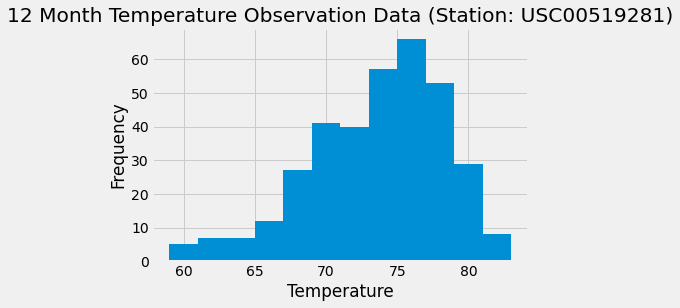

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temperatures=session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station==station_activity[0][0]).\
    filter(Measurement.date>=old_date).all()

# Save the query into a Pandas dataframe
year_temp_df=pd.DataFrame(year_temperatures,columns=["Date","Temperature °F"]).set_index("Date")

# Plot the data into a histogram
plt.hist(year_temp_df,bins=12)

# Format the plot
plt.title(f"12 Month Temperature Observation Data (Station: {station_activity[0][0]})")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Save the plot as a .png file
plt.savefig("Images/12_Month_Temp.png")

# Display the plot
plt.show()

# Close session

In [18]:
# Close Session
session.close()